In [ ]:
########  TESTING BLOCK  ########
GLOBAL_TEST_FILE = data_file
########  TESTING BLOCK  ########

In [1]:
"""
把csv或excel檔案轉換成dataframe
以供後續的pandas操作
"""

import pandas as pd
import numpy as np
from datetime import datetime

def readStock_file(file, filetype='csv'):


    if filetype == 'excel':
        df = pd.read_excel(file, engine='openpyxl', parse_dates=True, header=None)
    else:
        df = pd.read_csv(file)

    # 取代原本的 column 名稱
    # 檔案的日期與開高低收需要照這個順序
    colume_name = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    df.columns = colume_name

    # 用日期這一行當做 df 的索引
    df = df.set_index('Date')

    # 把日期轉成 datetime的格式(從string)
    df.index = pd.to_datetime(df.index)

    # 照日期排序並把空資料轉成numpy的nan
    df = df.sort_index()
    df = df.replace(r'^\s*-$', np.nan, regex=True)


    for col in df.columns:
        if(col=='Date'):
            continue;
        df[col] = np.array([float(x) for x in df[col]])

    return df

In [2]:
class trade:

    
    """
    用於回測並模擬股票交易的模塊
    會在模擬交易時記錄價格並計算出投報率等數據
    
    建構式參數：
        ticker 是放了股價資料的 pandas dataframe
        comission 是手續費
        tax 是交易稅
        holding_limit 是持有股票上限
        print_trading 是否在result()時 印出交易資料
        print_returnRate 是否在result()時 印出投資報酬率
        print_tradingTimes 是否在result()時 印出交易次數

    成員變數：
        principal 股票購入金額
        balance 餘額
        holding_tickers 持有股票數量
        returns 投資報酬率
        trading_nums 交易次數
    """
    __comission = 0
    def __init__(self, ticker ,comission=0, tax=0, holding_limit=0,
                    print_trading=False, print_returnRate=False, print_tradingTimes=False):


        self.comission = comission
        self.tax = tax
        self.ticker = ticker
        self.holding_limit = holding_limit

        self.print_trading = print_trading
        self.print_returnRate = print_returnRate
        self.print_tradingTimes = print_tradingTimes

        self.principal = 0
        self.balance = 0
        self.holding_tickers = 0
        self.returns = 0
        self.trading_nums = 0

    """
    模擬買入股票
    這裡會印出買入的日期與價格

    操作流程：
        購入金額設為 含手續費的當日收盤價
        餘額減去 含手續費的當日收盤價
        股票持有數量加一
    """
    def buy(self):
        if((self.holding_limit == 0) or
            self.holding_tickers < self.holding_limit):

            if self.print_trading:
                date = datetime.strftime(self.date,'%Y/%m/%d')
                close_price = round(self.position['Close'],1)
                print('\t{} buy  {}'.format(date,close_price))

            if(self.principal == 0):
                self.principal = self.position['Close'] * (1 + self.comission)

            self.balance -= self.position['Close'] * (1 + self.comission)
            self.holding_tickers = self.holding_tickers + 1

        return None

    """
    模擬賣出股票
    這裡會印出賣出的日期與價格

    操作流程：
        購入金額設為 含手續費的當日收盤價
        餘額加回 含手續費與交易稅的當日收盤價
        股票持有數量減一
        交易次數加一(買入+賣出算一次)

        投報率算法：餘額 / 購入金額
        累計投報率：把所有投報率"加起來"
    """
    def sell(self):
        if(self.holding_tickers):
            if self.print_trading:
                date = datetime.strftime(self.date,'%Y/%m/%d')
                close_price = round(self.position['Close'] ,1)
                print('\t{} sell {}'.format(date,close_price))

            self.balance += self.position['Close'] * (1 - self.comission - self.tax)

            self.returns += (self.balance/self.principal)
            self.principal, self.balance = 0,0
            self.holding_tickers = self.holding_tickers - 1;

            self.trading_nums = self.trading_nums+1
        return None

    """
    run()的時候，會在每一個日期逐一執行next
    實際在使用的時候需要複寫這個函式(用繼承的方式)
    否則會使用預設的next()

    預設：
        不論條件，每天買兩次賣一次
    """
    def next(self):

        self.buy()
        self.buy()
        self.sell()
        return None

    """
    在每一個日期逐一執行 next()
    而next()內會判斷是否需要在當天進行買入或賣出
    """
    def run(self):
        for index, row in self.ticker.iterrows():
            self.position = row
            self.date = index

            self.next()

        for _i in range(self.holding_tickers):
            self.sell()

    """
    返回投資報酬率
    並依照條件印出相關交易資料
    """
    def result(self):


        return_rate = round(self.returns *100, 4)

        if self.print_tradingTimes:
            print("\ttrading times : ", self.trading_nums)

        if self.print_returnRate:
            print("\treturn rate : {r}%".format(r=return_rate))

        return return_rate

In [3]:
"""
計算指標與信號常用的小工具
例如是否交叉，是否到達停損點等等
"""
import numpy as np

# 移動停損
# stop_loss 低於股價最高點多少比例就賣出
def moving_stop_loss(dw, stop_loss = 0.2):

    holding = 0 # 是否有持股
    high = 0 # 股票最高點

    # 如果沒有賣出信號這個欄位便新增
    if not 'sell' in dw:
        dw['sell'] = np.zeros(dw.shape[0])


    for index, row in dw.iterrows():
        if row['buy'] == 1:
            holding = 1


        # 持股時會持續記錄最高收盤價
        # 並判斷是否要賣出
        if holding:
            # 低於最高收盤價一定比例
            # 就產生賣出信號
            if row['Close'] < high*(1-stop_loss) :
                row['sell'] = 1

                holding = 0
                high = 0

            high = max(row['Close'], high)

    return dw

# 線a 是否在第 i 天向上穿出線b
def crossover(dw, i , a, b):
    if (((dw.iloc[i][a] > dw.iloc[i][b]) and
        (dw.iloc[i-1][a] < dw.iloc[i-1][b])) and
        (dw.iloc[i][a] > dw.iloc[i-1][a])):

        return 1;

In [5]:
"""
這裡的函式可以用來計算指標
以價格動能相關的指標為主
"""
import pandas as pd
def KD(ticker,RSVn = 9,RSVt = 3,Kt = 3,):
    tmp = pd.DataFrame(index=ticker.index)
    tmp['max_close'] = ticker['Close'].rolling(RSVn).max()
    tmp['min_close'] = ticker['Close'].rolling(RSVn).min()
    tmp['RSV'] = (ticker['Close'] - tmp['min_close'])/(tmp['max_close']-tmp['min_close'])*100

    tmp['k'] = tmp['RSV'].rolling(RSVt).mean()
    tmp['d'] = tmp['k'].rolling(Kt).mean()

    return tmp['k'], tmp['d']


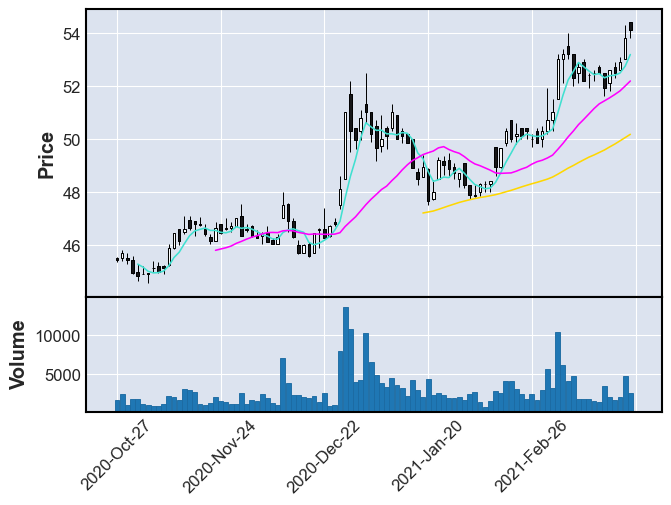

In [16]:
"""
放各種不同的股票策略
用上面的指標與是否停損等條件
判斷是否要買進賣出
"""
import pandas as pd
import talib
import numpy as np
import mplfinance as mpf

stop_loss = 0.2
"""
只使用KD指標作為買入賣出的判斷
高點線以上黃金交叉就買入
地點線以下死亡交叉就賣出
參數：
    ticker 股價 dataframe
    RSVn RSV計算最高股價與最低股價取幾天為區間
    RSVt 計算K時，平滑RSV(移動平均) 取幾天為區間
    Kt 計算D時，平滑K(移動平均) 取幾天為區間
    upperBound KD高於這個點就買入
    lowerBound KD低於這個點就賣出
    short_stop_loss 移動停損率
"""
def pure_KD(ticker, RSVn = 9,
                        RSVt = 3,
                        Kt = 3,
                        upperBound = 70,
                        lowerBound = 30,
                        short_stop_loss=True,):

    dw = ticker
    dw['slowk'], dw['slowd'] = indicator.KD(ticker, RSVn, RSVt, Kt)

    dw['signal'] = 0.0
    dw['signal'][RSVn:]  = np.where((dw['slowk'][RSVn:]
                                                > dw['slowd'][RSVn:]), 1.0, 0.0)

    # positon 是 1 便是 k 向上穿出 d
    #           -1則是 k 向下穿出 d
    # 這裡的黃金與死亡交叉定義比較寬鬆
    # 不限定 k或d 一定要往上或往下
    dw['positon'] = dw['signal'].diff()

    # k 向上穿出並大於高點線就買入
    dw['buy'] = np.where((dw['slowk'] > upperBound) & (dw['positon'] == 1 ), 1.0, 0.0)

    # 是否進行移動停損
    if short_stop_loss:
        dw = moving_stop_loss(dw, 0.2)
    else :

        # k 向下穿出並小於低點線就賣出
        dw['sell'] = np.where((dw['slowk'] < lowerBound) & (dw['positon'] == -1 ), 1.0, 0.0)

    dw.iloc[:, 0] = pd.to_datetime(stocks.iloc[:, 0], format = "%d/%m/%Y")

    #取最新100筆資料
    dw = stocks.tail(100)

    #繪圖 (股票資料、印出成交量、設定風格(蠟燭圖)、移動平均線(5, 20, 60))
    mpf.plot(dw, volume = True, type = 'candle', mav = (5, 20, 60))
    return dw

"""
使用三條均線進行判斷
產生金三角就買入
賣出則只使用移動停損
參數：
    ticker 股價 dataframe
    ma_window_short 第一條均線的區間
    ma_window_mid   第二條均線的區間
    ma_window_long  第三條均線的區間
    tolerence_interval  金三角的容許範圍
"""
def tripleMA_stopLoss(  ticker,
                ma_window_short = 7,
                ma_window_mid = 15,
                ma_window_long = 21,
                tolerence_interval = 7):

    dw = ticker

    # 計算三條平均線
    dw['ma_short'] = dw['Close'].rolling(ma_window_short).mean()
    dw['ma_mid'] = dw['Close'].rolling(ma_window_mid).mean()
    dw['ma_long'] = dw['Close'].rolling(ma_window_long).mean()

    # 初始化 買入信號的欄位
    dw['buy'] = np.zeros(dw.shape[0])
    if dw.shape[0] > ma_window_long:

        # 上一次 短線向上穿出中線 距離現在幾天
        last_cross_mid = tolerence_interval
        # 上一次 短線向上穿出長線 距離現在幾天
        last_cross_long = tolerence_interval
        for i in range(ma_window_long, dw.shape[0]):

            if crossover(dw, i, 'ma_short', 'ma_mid'):
                last_cross_mid = 0
            if crossover(dw, i, 'ma_short', 'ma_long'):
                last_cross_long = 0

            # 容許範圍內，短線是否向上穿出中線，短線是否向上穿出長線
            # 如果都有，且中線也向上穿出長線
            # 就判斷為金三角
            if (crossover(dw, i, 'ma_mid', 'ma_long') and
                last_cross_mid < tolerence_interval and
                last_cross_long < tolerence_interval) :

                # 金三角買入
                dw['buy'][i] =  1

                # 重置上一次短線穿出 距離現在幾天
                last_cross_mid = tolerence_interval
                last_cross_long = tolerence_interval

            last_cross_mid = last_cross_mid+1
            last_cross_long = last_cross_long+1

    # 賣出信號 僅使用移動停損
    dw = moving_stop_loss(dw, 0.2)
    return dw

"""
使用威廉指標進行判斷
會先判斷股價是否是近期最高點
如果是的話，低於低點線會買入
如果不是的話，高於高點線賣出
參數：
    ticker 股價 dataframe
    n 威廉指標的計算區間
    tolerence_interval 近期最高點的判斷天數
    lowerBound 低點線
    upperBound 高點線
    short_stop_loss 移動停損率
"""
def WMR(ticker, n = 14, tolerence_interval = 4, upperBound = 80, lowerBound = 20, short_stop_loss = True):
    dw = ticker

    # n 天內最高收盤價
    dw['current_high'] = dw['Close'].rolling(n).max()
    # n 天內最低收盤價
    dw['current_low'] = dw['Close'].rolling(n).min()

    # 威廉指標
    dw['W%R'] = (dw['current_high'] - dw['Close'])/(dw['current_high']-dw['current_low'])*100

    # tolerence_interval 期間內最高收盤價
    dw['HIGH_current_high'] =  dw['High'].rolling(tolerence_interval).max()

    # 是近期最高，且低於地點線，買入
    dw['buy'] = np.where((dw['W%R'] < lowerBound) & (dw['High'] == dw['HIGH_current_high'] ), 1.0, 0.0)

    # 是否進行移動停損
    if short_stop_loss:
        dw = moving_stop_loss(dw, 0.2)
    else :

        # 不是近期最高，且高於高點線，賣出
        dw['sell'] = np.where((dw['W%R'] > upperBound) & (dw['High'] != dw['HIGH_current_high']  ), 1.0, 0.0)


    return dw


########  TESTING BLOCK  ########
data_file = "../parse_data/data/splited/1210.csv"
ticker = readStock_file(data_file)
ticker = ticker.tail(100)
mpf.plot(ticker, volume = True, type = 'candle', mav = (5, 20, 60))
########  TESTING BLOCK  ########

In [12]:
"""
main()的部分
把上面的所有東西統合起來
用模擬交易去跑上述的策略
"""
import pandas as pd
import numpy as np
import glob
from functools import partial

########  Basic Settings  ########
print_format = {'tradingRecord'     : False, # 交易記錄
                'tradingNum'        : True,# 交易次數
                'fileName'          : True, # 逐一顯示檔案名稱
                'fileNameNewLine'   : True, # 每一個檔案跑完是否加換行
                'returnRate'        : True, # 投資報酬率
                }

# 用正則表示式表示有哪些檔案
file_pattern = "../parse_data/data/splited/1210.csv"

# 選取下列策略中的哪一個
choose_strategy = 'WMR'
########  Basic Settings  ########

########  Strategiy Configuration  ########

# 用functools.partial()把function的參數儲存起來
# 之後呼叫就不需要再傳入重複的參數
strategies = {
    'WMR' : partial(
        WMR,
        short_stop_loss=True,),      # 移動停損

    'Complete_KD' : partial(
        pure_KD,
        short_stop_loss=True,),       # 移動停損

    'tripleMA_stopLoss' : partial(
        tripleMA_stopLoss,
        ma_window_short = 7,        # 第一條均線的區間
        ma_window_mid = 15,         # 第二條均線的區間
        ma_window_long = 21,        # 第三條均線的區間
        tolerence_interval = 7),    # 金三角的容許範圍
}
########  Strategiy Configuration  ########

# 在新的 class中表示出什麼時候買
# 例如 當self.position的買入信號是1的時候買
class derieved(trade):

    def next(self):
        if(self.position['buy'] == 1):
            self.buy()
        if(self.position['sell'] == 1):
            self.sell()


returnRates = {}
for data_file in glob.glob(file_pattern):

    if print_format['fileName']:
        print(data_file, end='\n' if print_format['fileNameNewLine'] else '')

    # 自己寫的 tools.readStock_file
    ticker = readStock_file(data_file)

    dw = strategies[choose_strategy](ticker)

    # 手續費是0.1425%
    # 股票交易稅是0.3%
    # 持有上限是1
    bakctesting = derieved(dw, 0.001425, 0.003, 1,
                    print_trading=print_format['tradingRecord'],
                    print_tradingTimes=print_format['tradingNum'],
                    print_returnRate=print_format['returnRate'])


    bakctesting.run()

    # result()會傳回投資報酬率
    # 同時也會 print出交易記錄等資訊
    result = bakctesting.result()

    # 如果投報率非 None
    # 便存入 returnRates 這個dictionary
    if result:
        returnRates[data_file] = result

# 把 returnRates 內所有的投報率轉換成 numpy 陣列
returnRates_arr = np.fromiter(returnRates.values(), dtype=float)
# 用 numpy 加總
final_return_rate = round(returnRates_arr.sum(), 4)

print("\nFinal total return rate : {}%".format(final_return_rate))

# 依照 投報率 進行排序，由高到低
returnRates = dict(sorted(returnRates.items(), key=lambda item: item[1], reverse=True))
print("Highest 4 return rate :")

# 列出 top3 的投報率
counter = 0
for key, value in returnRates.items():
    print("\t\"{}\" return rate : {}%".format(key, value))
    counter = counter+1
    if counter == 4:
        break;

        

../parse_data/data/splited\1210.csv
	trading times :  70
	return rate : 552.8236%
../parse_data/data/splited\1217.csv
	trading times :  67
	return rate : -132.82%
../parse_data/data/splited\1219.csv
	trading times :  49
	return rate : -32.8432%
../parse_data/data/splited\1220.csv
	trading times :  49
	return rate : 54.9435%
../parse_data/data/splited\1225.csv
	trading times :  55
	return rate : 805.5394%
../parse_data/data/splited\1227.csv
	trading times :  44
	return rate : 145.3438%
../parse_data/data/splited\1236.csv
	trading times :  30
	return rate : 157.472%

Final total return rate : 1550.4591%
Highest 4 return rate :
	"../parse_data/data/splited\1225.csv" return rate : 805.5394%
	"../parse_data/data/splited\1210.csv" return rate : 552.8236%
	"../parse_data/data/splited\1236.csv" return rate : 157.472%
	"../parse_data/data/splited\1227.csv" return rate : 145.3438%
